File paths

In [1]:
train_file = '/work/data/splits/splits_0.050/train.json'
val_file = '/work/data/splits/splits_0.050/val.json'
test_file = '/work/data/splits/splits_0.050/test.json'
import os

path_to_save = '/work/data/models14_6'
os.system(f'mkdir -p {path_to_save}')
path_to_res = '/work/data/results/14_6_2023_tp_graph_5re.txt'

import

In [2]:
%load_ext autoreload
%autoreload 2
import json
import dgl
from sklearn.metrics import f1_score
import torch as th
import dgl.nn.pytorch as dglnn
import torch.nn as nn
from dgl.dataloading import GraphDataLoader
import torch.nn.functional as F
import networkx as nx
import warnings
from feature_extraction.base_featurizer import BaseFeaturizer
import torch
from graph_construction.tps_graph import create_dummy_dgl_graph, tps_graph
import numpy as np

from dgl_classifier.trainer import GraphDataset,snap_pred, tps_to_dgl, get_clasification_vec,\
tps_graph_const, extract_data, runner


import warnings

from preprocessing.utils import load_BGPS_from_json
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [3]:
#seed
dgl.seed(1223)

Model

In [4]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.dropout = torch.nn.Dropout(.5)
        self.conv1 = dglnn.RelGraphConv(in_dim, hidden_dim, 9, num_bases=9,regularizer='basis')
        #self.conv1 = dglnn.GraphConv(in_dim, hidden_ˇdim)
        self.conv2 = dglnn.RelGraphConv(hidden_dim, hidden_dim, 9, num_bases=9,regularizer='basis')
        #self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h, rel_types):
        # Apply graph convolution and activation.
        h = self.dropout(h)
        h = F.relu(self.conv1(g, h, rel_types))
        h = self.dropout(h)
        h = F.relu(self.conv2(g, h, rel_types))
        h = self.dropout(h)
        with g.local_scope():
            g.ndata['node_features'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'node_features')
            return F.softmax( self.classify(hg), dim=1)
            #return F.sigmoid( self.classify(hg))

#model = Classifier(113, 20, 1)

hyperparameters

In [5]:
early_stop =500
#model = Classifier(254, 64, 2)
model = Classifier(254, 64, 2)
#lr = 0.01
lr = 0.001
#wd = 5e-4
wd = 0.001
epochs = 300
#epochs = 100
add_thres=False
thres = 0.5
verbosity=0

In [6]:
train_dataloader, val_dataloader, test_dataloader = extract_data(train_file, val_file, test_file, community_no=100, batch_size = 50, verbose=True,  is_run_clust=True, clust_verbose=False)

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return th.as_tensor(data, dtype=dtype)


# of Removed: 37
# of Removed: 12
# of Removed: 10
# of predicate feats not in validation 88
# of predicate feats not in test 104
Training dataset size 249
Validation dataset size 84
Test dataset size 86


In [7]:
#best_model_path = runner(train_dataloader,val_dataloader,test_dataloader,model, early_stop, lr, wd, epochs, path_to_res, path_to_save=path_to_save,loss_type='mse')
best_model_path = runner(train_dataloader,val_dataloader,test_dataloader,model, 
                         early_stop, lr, wd, epochs, path_to_res, 
                         path_to_save=path_to_save,add_thres = add_thres, pred_thres=thres,
                        verbosity=verbosity)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Done!


In [8]:
import json

In [9]:
results = json.load(open(path_to_res))

In [10]:
#print('best f1', np.max(results['val_f1']), np.argmax(results['val_f1']))
best_f1_val= round(results['val_f1'][np.argmax(results['val_f1'])],3)
corr_f1_train = round(results['train_f1'][np.argmax(results['val_f1'])],3)
corr_f1_test = round(results['test_f1'][np.argmax(results['val_f1'])],3)

corr_prec_val= round(results['val_prec'][np.argmax(results['val_f1'])],3)
corr_prec_train = round(results['train_prec'][np.argmax(results['val_f1'])],3)
corr_prec_test = round(results['test_prec'][np.argmax(results['val_f1'])],3)

corr_rec_val= round(results['val_recall'][np.argmax(results['val_f1'])],3)
corr_rec_train = round(results['train_recall'][np.argmax(results['val_f1'])],3)
corr_rec_test = round(results['test_recall'][np.argmax(results['val_f1'])],3)

print('best f1 val', results['val_f1'][np.argmax(results['val_f1'])])
print('corr f1 train', results['train_f1'][np.argmax(results['val_f1'])])
print('corr f1 test', results['test_f1'][np.argmax(results['val_f1'])])
#print('best f1 train', np.max(results['train_f1']), np.argmax(results['train_f1']))
import pandas as pd
pd.DataFrame.from_dict({'F1': 
                        {'Train': corr_f1_train, 'Val': best_f1_val, 'Test': corr_f1_test },
                       'Precision':  
                         {'Train': corr_prec_train, 'Val': corr_prec_val, 'Test': corr_prec_test},
                        'Recall' :
                         {'Train': corr_rec_train, 'Val': corr_rec_val, 'Test': corr_rec_test} 
                       })

best f1 val 0.7870257037943696
corr f1 train 0.7557784995125149
corr f1 test 0.6774916013437849


,F1,Precision,Recall
Train,0.756,0.781,0.734
Val,0.787,0.940,0.679
Test,0.677,0.619,0.763


In [11]:
np.argmax(results['val_f1'])

23

In [12]:
import matplotlib.pyplot as plt

(0.0, 1.0)

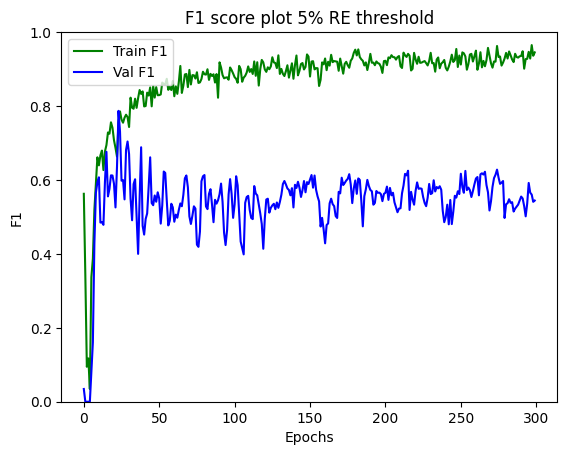

In [13]:
plt.title('F1 score plot 5% RE threshold')
plt.ylabel('F1')
plt.xlabel('Epochs')
plt.plot(results['train_f1'],'-g', label='Train F1')
plt.plot(results['val_f1'],'-b', label='Val F1')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])

In [14]:
list(results.keys())

['train_loss',
 'val_loss',
 'test_loss',
 'train_f1',
 'val_f1',
 'test_f1',
 'train_prec',
 'val_prec',
 'test_prec',
 'train_recall',
 'val_recall',
 'test_recall']

corr precision train 0.7814514152783099
corr precision val 0.9403508771929825
corr precision test 0.619360902255639


(0.0, 1.0)

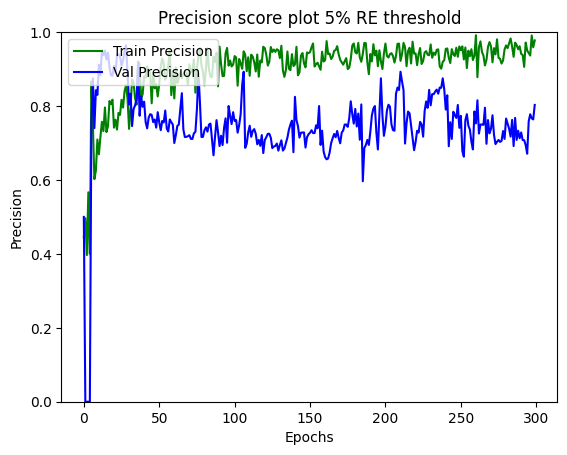

In [15]:
print('corr precision train', results['train_prec'][np.argmax(results['val_f1'])])
print('corr precision val', results['val_prec'][np.argmax(results['val_f1'])])
print('corr precision test', results['test_prec'][np.argmax(results['val_f1'])])
plt.title('Precision score plot 5% RE threshold')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.plot(results['train_prec'],'-g', label='Train Precision')
plt.plot(results['val_prec'],'-b', label='Val Precision')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])

corr recall train 0.7343285024154589
corr recall val 0.6793478260869565
corr recall test 0.763157894736842


(0.0, 1.0)

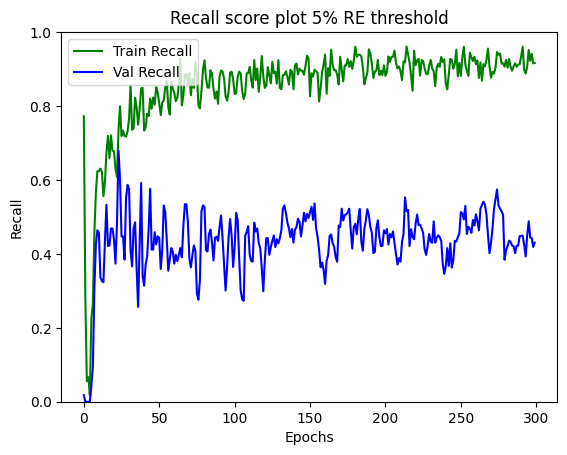

In [16]:
print('corr recall train', results['train_recall'][np.argmax(results['val_f1'])])
print('corr recall val', results['val_recall'][np.argmax(results['val_f1'])])
print('corr recall test', results['test_recall'][np.argmax(results['val_f1'])])
plt.title('Recall score plot 5% RE threshold')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.plot(results['train_recall'],'-g', label='Train Recall')
plt.plot(results['val_recall'],'-b', label='Val Recall')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])

In [17]:
import torch
model = torch.load(best_model_path)
model.eval()
model

Classifier(
  (dropout): Dropout(p=0.5, inplace=False)
  (conv1): RelGraphConv(
    (linear_r): TypedLinear(in_size=254, out_size=64, num_types=9, regularizer=basis, num_bases=9)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (conv2): RelGraphConv(
    (linear_r): TypedLinear(in_size=64, out_size=64, num_types=9, regularizer=basis, num_bases=9)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (classify): Linear(in_features=64, out_features=2, bias=True)
)

In [18]:
best_model_path
#path_to_res

'/work/data/models14_6/best_f1_model_24.pt'

In [19]:
from dgl_classifier.trainer import predict2samples
print(train_file)
train_data, val_data,test_data = predict2samples(model,train_file, val_file, test_file, community_no=100, verbose=True, clust_verbose=False, clust_load_path='/work/data/confs/14June/pred_clust.json')

/work/data/splits/splits_0.050/train.json


In [20]:
for k in train_data.keys():
    print(train_data[k])
    break

{'bloom_runtime': 0.067109028, 'jena_runtime': 0.048155545, 'leapfrog': 41030009, 'path': '/leapfrog-rdf-benchmark/results/optionals/Op3', 'gt': False, 'bgp_construction_duration': 0.00010418891906738281, 'tps_const_duration': 0.00040721893310546875, 'raw_pred': [[0.9250120520591736, 0.07498788088560104]], 'prediction': 0, 'inference_time': 0.014194726943969727}


Average runtime on workload

In [21]:
from dgl_classifier.post import *
train_rt,oracle_rt_train, avg_train, oracle_avg_train = avg_runtime(train_data)
#_,_, avg_train_jena, avg_train_blf, lf_train = avg_runtime_type(train_data, leaf=False)
j_rt_train,bf_rt_train, avg_train_jena, avg_train_blf = avg_runtime_type(train_data, leaf=False)

val_rt,oracle_rt_val, avg_val,oracle_avg_val = avg_runtime(val_data)
#_,_, avg_val_jena, avg_val_blf, lf_val = avg_runtime_type(val_data, leaf=False)
j_rt_val,bf_rt_val, avg_val_jena, avg_val_blf = avg_runtime_type(val_data, leaf=False)

test_rt,oracle_rt_test, avg_test,oracle_avg_test = avg_runtime(test_data)
#_,_, avg_test_jena,avg_test_blf, lf_test = avg_runtime_type(test_data, leaf=False)
j_rt_test,bf_rt_test, avg_test_jena,avg_test_blf = avg_runtime_type(test_data, leaf=False)

In [22]:
"""print('Train\n','\tWith Predictions ',round(avg_train,3),', Jena: ', round(avg_train_jena,3), ', Bloom Filter',round(avg_train_blf,3), ', LeapFrog',round(np.sum(lf_train)/len(lf_train),3),', Oracle',round(oracle_avg_train,3))
print('Validation\n','\tWith Predictions ',round(avg_val,3),', Jena: ', round(avg_val_jena,3), ', Bloom Filter',round(avg_val_blf,3), ', LeapFrog',round(np.sum(lf_val)/len(lf_val),3),', Oracle',round(oracle_avg_val,3))
print('Test\n','\tWith Predictions ',round(avg_test,3),', Jena: ', round(avg_test_jena,3), ', Bloom Filter',round(avg_test_blf,3), ', LeapFrog',round(np.sum(lf_test)/len(lf_test),3),', Oracle',round(oracle_avg_test,3))"""
print('Train\n','\tWith Predictions ',round(avg_train,3),', Jena: ', round(avg_train_jena,3), ', Bloom Filter',round(avg_train_blf,3),', Oracle',round(oracle_avg_train,3))
print('Validation\n','\tWith Predictions ',round(avg_val,3),', Jena: ', round(avg_val_jena,3), ', Bloom Filter',round(avg_val_blf,3), ', Oracle',round(oracle_avg_val,3))
print('Test\n','\tWith Predictions ',round(avg_test,3),', Jena: ', round(avg_test_jena,3), ', Bloom Filter',round(avg_test_blf,3),', Oracle',round(oracle_avg_test,3))
#print(avg_val,avg_val_jena,avg_val_blf)
#print(avg_test,avg_test_jena,avg_test_blf)

Train
 	With Predictions  7.434 , Jena:  7.434 , Bloom Filter 8.161 , Oracle 7.407
Validation
 	With Predictions  8.622 , Jena:  8.627 , Bloom Filter 9.019 , Oracle 8.466
Test
 	With Predictions  4.463 , Jena:  4.189 , Bloom Filter 4.637 , Oracle 4.179


Relative difference in average time

In [23]:
print(f'Train: relative Improvement : {round(((avg_train_jena-avg_train)/avg_train_jena)*100,2)}')
print(f'Val: relative Improvement : {round(((avg_val_jena-avg_val)/avg_val_jena)*100,2)}')
print(f'Test: relative Improvement : {round(((avg_test_jena-avg_test)/avg_test_jena)*100,2)}')

Train: relative Improvement : 0.01
Val: relative Improvement : 0.05
Test: relative Improvement : -6.54


Optimal relative difference in average for oracle

In [24]:
print(f'Train: relative Improvement : {round(((avg_train_jena-oracle_avg_train)/avg_train_jena)*100,2)}')
print(f'Val: relative Improvement : {round(((avg_val_jena-oracle_avg_val)/avg_val_jena)*100,2)}')
print(f'Test: relative Improvement : {round(((avg_test_jena-oracle_avg_test)/avg_test_jena)*100,2)}')

Train: relative Improvement : 0.36
Val: relative Improvement : 1.86
Test: relative Improvement : 0.24


In [25]:
from dgl_classifier.post import *
JB_train_rt, oracle_rt_train = get_runtime(train_data)
J_train_rt, B_train_rt = get_runtimes_wo_pred(train_data)

JB_val_rt, oracle_rt_val = get_runtime(val_data)
J_val_rt, B_val_rt = get_runtimes_wo_pred(val_data)

JB_test_rt, oracle_rt_test = get_runtime(test_data)
J_test_rt, B_test_rt = get_runtimes_wo_pred(test_data)

In [26]:
save_figs = '/work/files/'

In [27]:
from dgl_classifier. trainer import predict2samples
train_data, val_data,test_data = predict2samples(model,train_file, val_file, test_file, community_no=10, verbose=True, clust_verbose=False, clust_load_path='/work/data/confs/14June/pred_clust.json')

In [28]:
from dgl_classifier.post import *
JB_train_rt, oracle_rt_train = get_runtime(train_data)
J_train_rt, B_train_rt = get_runtimes_wo_pred(train_data)

JB_val_rt, oracle_rt_val = get_runtime(val_data)
J_val_rt, B_val_rt = get_runtimes_wo_pred(val_data)

JB_test_rt, oracle_rt_test = get_runtime(test_data)
J_test_rt, B_test_rt = get_runtimes_wo_pred(test_data)

Here, we investigate what the average runtime with JenaBloom (Prediction), Jena, BF and Oracle (perfect classifier). The metric is in S, here.

In [29]:
print('Train\n','\tWith Predictions ',round(np.mean(JB_train_rt),3),', Jena: ', round(np.mean(J_train_rt),3), ', Bloom Filter',round(np.mean(B_train_rt),3),', Oracle',round(np.mean(oracle_rt_train),3))
print('Validation\n','\tWith Predictions ',round(np.mean(JB_val_rt),3),', Jena: ', round(np.mean(J_val_rt),3), ', Bloom Filter',round(np.mean(B_val_rt),3), ', Oracle',round(np.mean(oracle_rt_val),3))
print('Test\n','\tWith Predictions ',round(np.mean(JB_test_rt),3),', Jena: ', round(np.mean(J_test_rt),3), ', Bloom Filter',round(np.mean(B_test_rt),3),', Oracle',round(np.mean(oracle_rt_test),3))

Train
 	With Predictions  7.434 , Jena:  7.434 , Bloom Filter 8.161 , Oracle 7.407
Validation
 	With Predictions  8.622 , Jena:  8.627 , Bloom Filter 9.019 , Oracle 8.466
Test
 	With Predictions  4.463 , Jena:  4.189 , Bloom Filter 4.637 , Oracle 4.179


Now, we look into the relative improvements that we make possible with our model.
So these a wrt. to the Jena runtimes, (Jena runtimes are the "true", runtimes)

In [30]:
def relative_improvements(JB_rt, J):
    return [(( j-jb)/j)*100 for jb, j in zip(JB_rt, J)] 
train_re_im = relative_improvements(JB_train_rt,J_train_rt)
val_re_im = relative_improvements(JB_val_rt,J_val_rt)
test_re_im = relative_improvements(JB_test_rt,J_test_rt)

In [31]:
o_train_re_im = relative_improvements(oracle_rt_train,J_train_rt)
o_val_re_im = relative_improvements(oracle_rt_val,J_val_rt)
o_test_re_im = relative_improvements(oracle_rt_val,J_test_rt)

In [32]:
def print_stat(re_s):
    print("Mean ", round(np.mean(re_s),3))
    print("STD ", round(np.std(re_s),3))
    print("Min ", round(np.min(re_s),3))
    print("25% ", round(np.quantile(re_s,q=0.25),3))
    print("50% ", round(np.quantile(re_s,q=0.5),3))
    print("75% ", round(np.quantile(re_s,q=0.75),3))
    print("Max ", round(np.max(re_s),3))

In [33]:
print_stat(train_re_im)

Mean  3.637
STD  8.912
Min  -26.933
25%  0.0
50%  0.0
75%  6.677
Max  74.439


In [34]:
print_stat(val_re_im)

Mean  4.607
STD  7.627
Min  -0.337
25%  0.0
50%  0.0
75%  7.374
Max  42.866


In [35]:
print_stat(test_re_im)

Mean  1.403
STD  10.314
Min  -49.981
25%  0.0
50%  0.0
75%  5.845
Max  23.677


Values below needs to be adjusted

In [36]:
#average in upper quantile:
temp = []
for idx,x in enumerate(val_re_im):
    if x > 6.36:
        temp.append(x)
print('Validation AVG (upper tier', round(np.mean(temp),3))
temp = []
for idx,x in enumerate(test_re_im):
    if x > 4.3:
        temp.append(x)
print('Test AVG (upper tier', round(np.mean(temp),3))

Validation AVG (upper tier 14.028
Test AVG (upper tier 9.902


In [37]:
for idx,x in enumerate(val_re_im):
    if x > np.quantile(val_re_im,q=0.75):
        print('Relative Improvement ',round(x,3),' JenaBloom RT ', round(JB_val_rt[idx],3),' Jena RT ', round(J_val_rt[idx],3), 'Absolute difference in MS',round((J_val_rt[idx] -JB_val_rt[idx] )*1e3,3))

Relative Improvement  9.158  JenaBloom RT  0.022  Jena RT  0.024 Absolute difference in MS 2.184
Relative Improvement  17.005  JenaBloom RT  0.026  Jena RT  0.031 Absolute difference in MS 5.242
Relative Improvement  10.751  JenaBloom RT  0.192  Jena RT  0.215 Absolute difference in MS 23.152
Relative Improvement  42.866  JenaBloom RT  0.028  Jena RT  0.048 Absolute difference in MS 20.636
Relative Improvement  22.282  JenaBloom RT  0.007  Jena RT  0.01 Absolute difference in MS 2.127
Relative Improvement  20.07  JenaBloom RT  0.027  Jena RT  0.034 Absolute difference in MS 6.777
Relative Improvement  26.28  JenaBloom RT  0.024  Jena RT  0.033 Absolute difference in MS 8.58
Relative Improvement  10.721  JenaBloom RT  0.005  Jena RT  0.006 Absolute difference in MS 0.641
Relative Improvement  11.749  JenaBloom RT  0.01  Jena RT  0.011 Absolute difference in MS 1.314
Relative Improvement  11.692  JenaBloom RT  0.07  Jena RT  0.08 Absolute difference in MS 9.322
Relative Improvement  8.15

In [38]:
for idx,x in enumerate(test_re_im):
    if x > np.quantile(test_re_im,q=0.75):
        print('Relative Improvement ',round(x,3),' JenaBloom RT ', round(JB_test_rt[idx],3),' Jena RT ', round(J_test_rt[idx],3), 'Absolute difference in MS',round((J_test_rt[idx] -JB_test_rt[idx] )*1e3,3))

Relative Improvement  11.458  JenaBloom RT  0.005  Jena RT  0.005 Absolute difference in MS 0.617
Relative Improvement  6.776  JenaBloom RT  0.009  Jena RT  0.01 Absolute difference in MS 0.656
Relative Improvement  21.363  JenaBloom RT  0.003  Jena RT  0.004 Absolute difference in MS 0.88
Relative Improvement  18.076  JenaBloom RT  0.017  Jena RT  0.021 Absolute difference in MS 3.747
Relative Improvement  6.555  JenaBloom RT  0.02  Jena RT  0.021 Absolute difference in MS 1.384
Relative Improvement  6.334  JenaBloom RT  0.037  Jena RT  0.039 Absolute difference in MS 2.476
Relative Improvement  13.542  JenaBloom RT  0.014  Jena RT  0.017 Absolute difference in MS 2.269
Relative Improvement  6.373  JenaBloom RT  0.027  Jena RT  0.029 Absolute difference in MS 1.832
Relative Improvement  7.784  JenaBloom RT  0.28  Jena RT  0.304 Absolute difference in MS 23.659
Relative Improvement  7.667  JenaBloom RT  0.052  Jena RT  0.056 Absolute difference in MS 4.291
Relative Improvement  8.653  

In [39]:
round((len([x for x in test_re_im if x > 0]) / len(test_re_im))*100,3)

40.698

In [40]:
round((len([x for x in train_re_im if x > 0]) / len(train_re_im))*100,3)

34.538

In [41]:
round((len([x for x in val_re_im if x > 0]) / len(val_re_im))*100,3)

39.286

In [42]:
round( np.mean(J_train_rt)- np.mean(JB_train_rt),3), ', Jena: ', round(np.mean(J_train_rt),3), ', Bloom Filter', round(np.mean(B_train_rt),3), ', Oracle', round(np.mean(oracle_rt_train),3),', JenaBloom', round(np.mean(JB_train_rt),3)

(0.001,
 ', Jena: ',
 7.434,
 ', Bloom Filter',
 8.161,
 ', Oracle',
 7.407,
 ', JenaBloom',
 7.434)

In [43]:
def improvement(J, JB):
    J = [x*1e3 for x in J]
    JB = [x*1e3 for x in JB]
    sum_J = np.sum(J)
    sum_JB = np.sum(JB)
    print(round(((sum_J-sum_JB)),3))
    return ((sum_J-sum_JB))
improvement(J_train_rt, JB_train_rt)
improvement(J_val_rt, JB_val_rt)
improvement(J_test_rt, JB_test_rt)

193.47
383.264
-23563.649


-23563.64910099993

In [44]:
def rt_improvement(J, JB):
    sum_J = np.sum(J)
    sum_JB = np.sum(JB)
    print(round( ((sum_J-sum_JB)/sum_J)*100,3))
    return ((sum_J-sum_JB)/sum_J)*100
rt_improvement(J_train_rt, JB_train_rt)
rt_improvement(J_val_rt, JB_val_rt)
rt_improvement(J_test_rt, JB_test_rt)

0.01
0.053
-6.541


-6.541211160346995

In [45]:
def speedup(J, JB):
    sum_J = np.sum(J)
    sum_JB = np.sum(JB)
    print(sum_J/sum_JB)
speedup(J_train_rt, JB_train_rt)
speedup(J_val_rt, JB_val_rt)
speedup(J_test_rt, JB_test_rt)

1.000104524705438
1.0005291707826327
0.9386039346736699


In [46]:
speedup(J_train_rt, oracle_rt_train)
speedup(J_val_rt, oracle_rt_val)
speedup(J_test_rt, oracle_rt_test)

1.0036463247311769
1.018975711138944
1.0024136072241754


In [47]:
import matplotlib.pyplot as plt

def bxp_rel_impr(re, title, save=None):
    plt.clf()
    plt.figure(figsize=(3,6))
    plt.ylabel('Relative Improvement (%)')
    plt.title(title)
    plt.boxplot(re)
    if save != None:
        plt.savefig(f'{save_figs}{save}.png')
    plt.show()

<Figure size 640x480 with 0 Axes>

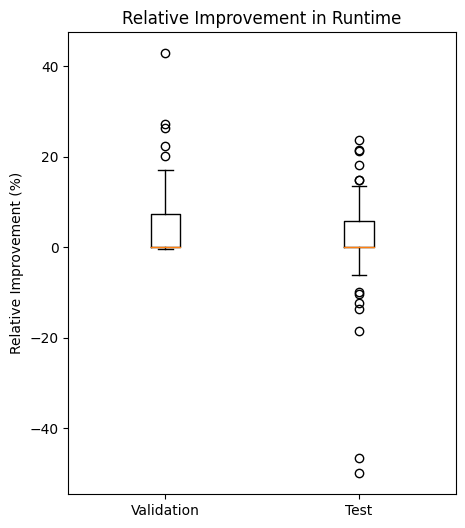

In [48]:
import pandas as pd

def bxp_rel_impr_w_both(re_val,re_test, title, save=None):
    for col_name,rel_impr  in zip(['Val Speedup','Test Speedup'], [re_val,re_test]):
        d = {col_name:rel_impr}
        df = pd.DataFrame(d)
        df.to_csv(f'{save_figs}{save}_{col_name}.csv', index = False)
    plt.clf()
    #plt.figure()
    fig, ax = plt.subplots(figsize=(5,6))
    data = {'Validation': re_val, 'Test': re_test}
    ax.boxplot(data.values())
    ax.set_xticklabels(data.keys())
    plt.ylabel('Relative Improvement (%)')
    plt.title(title)
    if save != None:
        plt.savefig(f'{save_figs}{save}.png', bbox_inches='tight')
    plt.show()
bxp_rel_impr_w_both(val_re_im,test_re_im, 'Relative Improvement in Runtime', save='rel_impro_rt')

In [49]:
for idx,x in enumerate(val_re_im):
    if x <0:
        print('Relative Decline ',round(x,3),' JenaBloom RT ', round(JB_val_rt[idx],3),' Jena RT ', round(J_val_rt[idx],3), 'Absolute difference in MS',round((J_val_rt[idx] -JB_val_rt[idx] )*1e3,3))

Relative Decline  -0.337  JenaBloom RT  0.018  Jena RT  0.018 Absolute difference in MS -0.061


In [50]:
for idx,x in enumerate(test_re_im):
    if x <0:
        print('Relative Decline ',round(x,3),' JenaBloom RT ', round(JB_test_rt[idx],3),' Jena RT ', round(J_test_rt[idx],3), 'Absolute difference in MS',round((J_test_rt[idx] -JB_test_rt[idx] )*1e3,3))

Relative Decline  -10.372  JenaBloom RT  0.013  Jena RT  0.012 Absolute difference in MS -1.245
Relative Decline  -1.438  JenaBloom RT  0.255  Jena RT  0.251 Absolute difference in MS -3.617
Relative Decline  -1.887  JenaBloom RT  0.261  Jena RT  0.256 Absolute difference in MS -4.84
Relative Decline  -9.94  JenaBloom RT  0.002  Jena RT  0.002 Absolute difference in MS -0.204
Relative Decline  -49.981  JenaBloom RT  0.055  Jena RT  0.037 Absolute difference in MS -18.48
Relative Decline  -3.107  JenaBloom RT  0.035  Jena RT  0.034 Absolute difference in MS -1.062
Relative Decline  -6.232  JenaBloom RT  0.061  Jena RT  0.058 Absolute difference in MS -3.606
Relative Decline  -18.426  JenaBloom RT  0.003  Jena RT  0.003 Absolute difference in MS -0.514
Relative Decline  -46.525  JenaBloom RT  0.067  Jena RT  0.046 Absolute difference in MS -21.386
Relative Decline  -12.292  JenaBloom RT  0.077  Jena RT  0.068 Absolute difference in MS -8.394
Relative Decline  -4.277  JenaBloom RT  0.228 

# How good are our "positive" prediction?

In [51]:
from dgl_classifier.post import get_BF_run_times

t_train_BF_runtimes, t_train_BF_oracle, t_train_BF_jena = get_BF_run_times(train_data)
t_val_BF_runtimes, t_val_BF_oracle, t_val_BF_jena = get_BF_run_times(val_data)
t_test_BF_runtimes, t_test_BF_oracle, t_test_BF_jena = get_BF_run_times(test_data)

In [52]:
print('Amount Predicted As Use BF')
print('Val: ', end = '')
print(len(t_val_BF_runtimes))
print('Test: ', end = '')
print(len(t_test_BF_runtimes))
print('Train: ', end = '')
print(len(t_train_BF_runtimes))

Amount Predicted As Use BF
Val: 47
Test: 38
Train: 106


In [53]:
print('Improvement in Validation')
print('JenaBloom: ')
print('Improvement in ms:', end= ' ')
improvement(t_val_BF_jena,t_val_BF_runtimes)
print('Relative Improvement (%):', end= ' ')
rt_improvement(t_val_BF_jena,t_val_BF_runtimes)
print('Oracle: ')
print('Improvement in ms:', end= ' ')
improvement(t_val_BF_jena,t_val_BF_oracle)
print('Relative Improvement (%):', end= ' ')
rt_improvement(t_val_BF_jena,t_val_BF_oracle)


print('Improvement in Test')
print('JenaBloom: ')
print('Improvement in ms:', end= ' ')
improvement(t_test_BF_jena,t_test_BF_runtimes)
print('Relative Improvement (%):', end= ' ')
rt_improvement(t_test_BF_jena,t_test_BF_runtimes)
print('Oracle: ')
print('Improvement in ms:', end= ' ')
improvement(t_val_BF_jena,t_val_BF_oracle)
print('Relative Improvement (%):', end= ' ')
rt_improvement(t_val_BF_jena,t_val_BF_oracle)

Improvement in Validation
JenaBloom: 
Improvement in ms: 591.454
Relative Improvement (%): 8.653
Oracle: 
Improvement in ms: 591.454
Relative Improvement (%): 8.653
Improvement in Test
JenaBloom: 
Improvement in ms: 467.715
Relative Improvement (%): 7.89
Oracle: 
Improvement in ms: 591.454
Relative Improvement (%): 8.653


8.652686621240262

# Old plots

In [54]:
def boxplots(jbf_rt, oracle_rt, jena_rt):
    for rt, title in zip([jbf_rt, oracle_rt, jena_rt], ['JenaBloom','Oracle', 'Jena']):
        print(title)
        print("Mean ", np.mean(rt))
        print("STD ", np.std(rt))
        print("Min ", np.min(rt))
        print("25% ", np.quantile(rt,q=0.25))
        print("50% ", np.quantile(rt,q=0.5))
        print("75% ", np.quantile(rt,q=0.75))
        print("Max ", np.max(rt))

        plt.clf()
        plt.figure(figsize=(3,6))
        plt.ylabel('Seconds')
        plt.title(title)
        plt.boxplot(rt)
        plt.show()
#boxplots(val_rt,oracle_rt_val,j_rt_val)

Validation Relative Runtime Improvement for Oracle
Mean  6.293506882109521
STD  7.481646635155949
Min  0.0
25%  0.0
50%  5.7310596340322375
75%  9.594890260122437
Max  42.86617701833492


<Figure size 640x480 with 0 Axes>

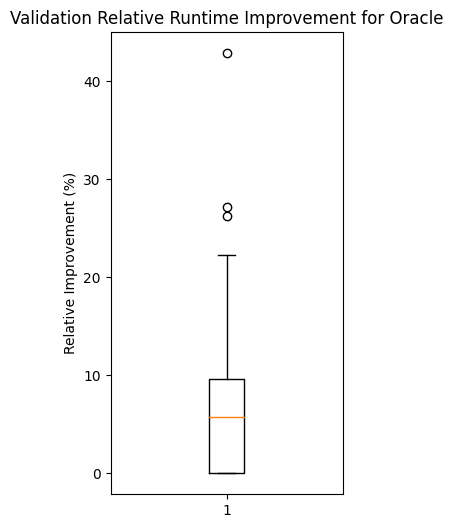

Test Relative Runtime Improvement for Oracle
Mean  4.719166737101756
STD  5.759712989191208
Min  0.0
25%  0.0
50%  2.5850219991638577
75%  7.7024995180602325
Max  23.67658765737796


<Figure size 640x480 with 0 Axes>

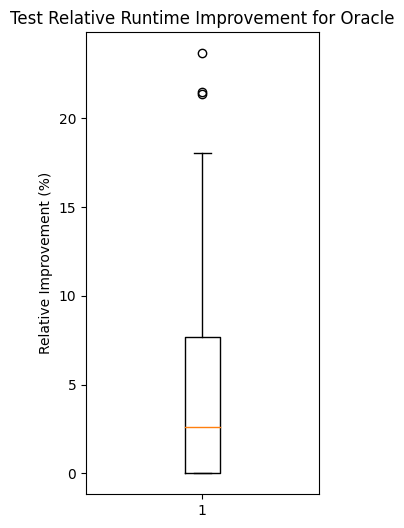

Validation Relative Runtime Improvement for Prediction
Mean  4.6067883967358965
STD  7.62724891462482
Min  -0.3365057746486611
25%  0.0
50%  0.0
75%  7.3735030773975465
Max  42.86617701833492


<Figure size 640x480 with 0 Axes>

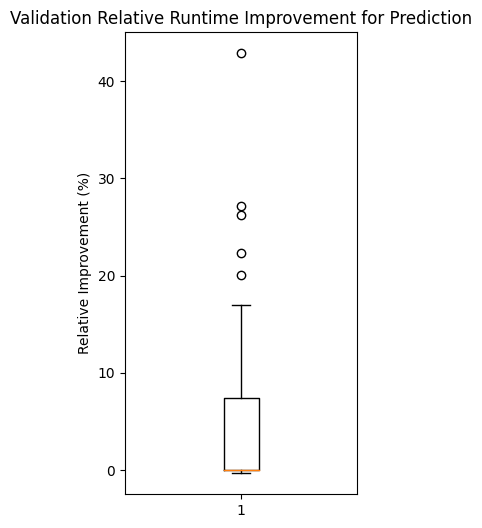

Relative Error  -0.337  JenaBloom RT  0.018  Jena RT  0.018 Absolute difference in MS 0.061
Relative Improvement  17.005  JenaBloom RT  0.026  Jena RT  0.031 Absolute difference in MS 5.242
Relative Improvement  10.751  JenaBloom RT  0.192  Jena RT  0.215 Absolute difference in MS 23.152
Relative Improvement  42.866  JenaBloom RT  0.028  Jena RT  0.048 Absolute difference in MS 20.636
Relative Improvement  22.282  JenaBloom RT  0.007  Jena RT  0.01 Absolute difference in MS 2.127
Relative Improvement  20.07  JenaBloom RT  0.027  Jena RT  0.034 Absolute difference in MS 6.777
Relative Improvement  26.28  JenaBloom RT  0.024  Jena RT  0.033 Absolute difference in MS 8.58
Relative Improvement  10.721  JenaBloom RT  0.005  Jena RT  0.006 Absolute difference in MS 0.641
Relative Improvement  11.749  JenaBloom RT  0.01  Jena RT  0.011 Absolute difference in MS 1.314
Relative Improvement  11.692  JenaBloom RT  0.07  Jena RT  0.08 Absolute difference in MS 9.322
Relative Improvement  13.635  J

<Figure size 640x480 with 0 Axes>

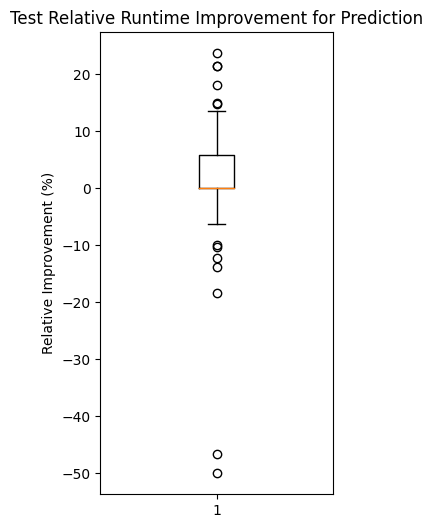

Relative Error  -10.372  JenaBloom RT  0.013  Jena RT  0.012 Absolute difference in MS 1.245
Relative Error  -1.438  JenaBloom RT  0.255  Jena RT  0.251 Absolute difference in MS 3.617
Relative Error  -1.887  JenaBloom RT  0.261  Jena RT  0.256 Absolute difference in MS 4.84
Relative Error  -9.94  JenaBloom RT  0.002  Jena RT  0.002 Absolute difference in MS 0.204
Relative Error  -49.981  JenaBloom RT  0.055  Jena RT  0.037 Absolute difference in MS 18.48
Relative Error  -3.107  JenaBloom RT  0.035  Jena RT  0.034 Absolute difference in MS 1.062
Relative Error  -6.232  JenaBloom RT  0.061  Jena RT  0.058 Absolute difference in MS 3.606
Relative Error  -18.426  JenaBloom RT  0.003  Jena RT  0.003 Absolute difference in MS 0.514
Relative Error  -46.525  JenaBloom RT  0.067  Jena RT  0.046 Absolute difference in MS 21.386
Relative Error  -12.292  JenaBloom RT  0.077  Jena RT  0.068 Absolute difference in MS 8.394
Relative Error  -4.277  JenaBloom RT  0.228  Jena RT  0.219 Absolute differe

In [55]:
def relative_importance_plot(j_bl_rt, j_rt, title, print_not_improve=False, improve_perc=None):
    re_s = [((jr-jb)/jr)*100 for jb, jr in zip(j_bl_rt, j_rt)]
    
    print(title)
    print("Mean ", np.mean(re_s))
    print("STD ", np.std(re_s))
    print("Min ", np.min(re_s))
    print("25% ", np.quantile(re_s,q=0.25))
    print("50% ", np.quantile(re_s,q=0.5))
    print("75% ", np.quantile(re_s,q=0.75))
    print("Max ", np.max(re_s))

    plt.clf()
    plt.figure(figsize=(3,6))
    plt.ylabel('Relative Improvement (%)')
    plt.title(title)
    plt.boxplot(re_s)
    plt.show()
    if print_not_improve:
        for idx,x in enumerate(re_s):
            if x < 0:
                print('Relative Error ',round(x,3),' JenaBloom RT ', round(j_bl_rt[idx],3),' Jena RT ', round(j_rt[idx],3), 'Absolute difference in MS',round((j_bl_rt[idx]- j_rt[idx])*1e3,3))
    if improve_perc != None:
        for idx,x in enumerate(re_s):
            if x > improve_perc:
                print('Relative Improvement ',round(x,3),' JenaBloom RT ', round(j_bl_rt[idx],3),' Jena RT ', round(j_rt[idx],3), 'Absolute difference in MS',round((j_rt[idx] -j_bl_rt[idx] )*1e3,3))
        
relative_importance_plot(oracle_rt_val, j_rt_val, 'Validation Relative Runtime Improvement for Oracle')
relative_importance_plot(oracle_rt_test, j_rt_test, 'Test Relative Runtime Improvement for Oracle')
relative_importance_plot(val_rt, j_rt_val, 'Validation Relative Runtime Improvement for Prediction', print_not_improve=True,improve_perc=9.5)
relative_importance_plot(test_rt, j_rt_test, 'Test Relative Runtime Improvement for Prediction', print_not_improve=True,improve_perc=9.5)

Validation Runtime Improvement for Oracle
Mean  160.652
STD  1397.923
Min  0.0
25%  0.0
50%  0.749
75%  4.992
Max  12895.253


<Figure size 640x480 with 0 Axes>

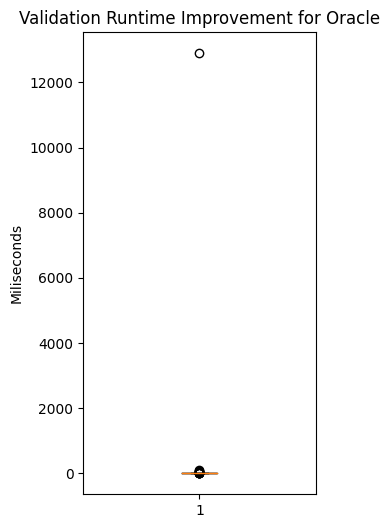

Test Runtime Improvement for Oracle
Mean  10.086
STD  40.904
Min  0.0
25%  0.0
50%  0.394
75%  4.155
Max  366.089


<Figure size 640x480 with 0 Axes>

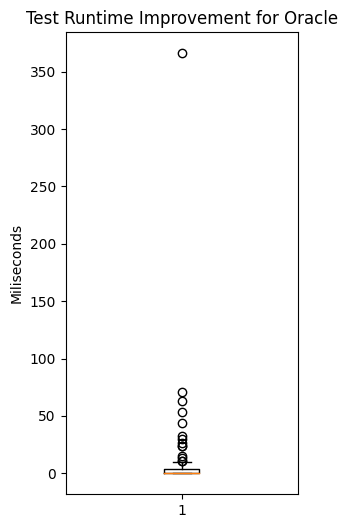

In [56]:
def absolute_gain(j_bl_rt, j_rt, title):
    re_s = [((jr-jb)*1e3) for jb, jr in zip(j_bl_rt, j_rt)]
    print(title)
    print("Mean ", round(np.mean(re_s),3))
    print("STD ", round(np.std(re_s),3))
    print("Min ", round(np.min(re_s),3))
    print("25% ", round(np.quantile(re_s,q=0.25),3))
    print("50% ", round(np.quantile(re_s,q=0.5),3))
    print("75% ", round(np.quantile(re_s,q=0.75),3))
    print("Max ", round(np.max(re_s),3))

    plt.clf()
    plt.figure(figsize=(3,6))
    plt.ylabel('Miliseconds')
    plt.title(title)
    plt.boxplot(re_s)
    plt.show()
absolute_gain(oracle_rt_val, j_rt_val, 'Validation Runtime Improvement for Oracle')
absolute_gain(oracle_rt_test, j_rt_test, 'Test Runtime Improvement for Oracle')

Cumulative runtime on workload

In [57]:
cum_pred_train = cum_runtime(train_data)
#jena_cum_train , blf_cum_train, lf_cum_train, oracle_cum_train = cum_runtime_type(train_data)
jena_cum_train , blf_cum_train, oracle_cum_train = cum_runtime_type(train_data, leaf=False)

cum_pred_val = cum_runtime(val_data)
jena_cum_val , blf_cum_val, oracle_cum_val = cum_runtime_type(val_data,leaf=False)
#jena_cum_val , blf_cum_val, lf_cum_val, oracle_cum_val = cum_runtime_type(val_data)

cum_pred_test = cum_runtime(test_data)
jena_cum_test , blf_cum_test, oracle_cum_test = cum_runtime_type(test_data, leaf=False)
#jena_cum_test , blf_cum_test, lf_cum_test, oracle_cum_test = cum_runtime_type(test_data)

In [58]:
print(f'Train:\n')
print(f'\tCumulative Runtime (with Predictions): {round(cum_pred_train,3)}')
print(f'\tCumulative Runtime (with Jena): {round(jena_cum_train,3)}')
print(f'\tCumulative Runtime (with BF): {round(blf_cum_train,3)}')
#print(f'\tCumulative Runtime (with LeapFrog): {round(lf_cum_train,3)}')
print(f'\tCumulative Runtime (with Oracle): {round(oracle_cum_train,3)}')

print(f'Val:\n')
print(f'\tCumulative Runtime (with Predictions): {round(cum_pred_val,3)}')
print(f'\tCumulative Runtime (with Jena): {round(jena_cum_val,3)}')
print(f'\tCumulative Runtime (with BF): {round(blf_cum_val,3)}')
#print(f'\tCumulative Runtime (with LeapFrog): {round(lf_cum_val,3)}')
print(f'\tCumulative Runtime (with Oracle): {round(oracle_cum_val,3)}')

print(f'Test:\n')
print(f'\tCumulative Runtime (with Predictions): {round(cum_pred_test,3)}')
print(f'\tCumulative Runtime (with Jena): {round(jena_cum_test,3)}')
print(f'\tCumulative Runtime (with BF): {round(blf_cum_test,3)}')
#print(f'\tCumulative Runtime (with LeapFrog): {round(lf_cum_test,3)}')
print(f'\tCumulative Runtime (with Oracle): {round(oracle_cum_test,3)}')

Train:

	Cumulative Runtime (with Predictions): 1850.948
	Cumulative Runtime (with Jena): 1851.141
	Cumulative Runtime (with BF): 2032.165
	Cumulative Runtime (with Oracle): 1844.416
Val:

	Cumulative Runtime (with Predictions): 724.273
	Cumulative Runtime (with Jena): 724.656
	Cumulative Runtime (with BF): 757.571
	Cumulative Runtime (with Oracle): 711.162
Test:

	Cumulative Runtime (with Predictions): 383.797
	Cumulative Runtime (with Jena): 360.234
	Cumulative Runtime (with BF): 398.759
	Cumulative Runtime (with Oracle): 359.366


In [59]:
print('best model epoch', np.argmax(results['val_f1']))

best model epoch 23


j_rt_train,bf_rt_train, j_rt_val,bf_rt_val, j_rt_test,bf_rt_test

In [60]:
def bxp_plot(rt, ylim=None, title=None):
    print("Mean ", np.mean(rt))
    print("STD ", np.std(rt))
    print("Min ", np.min(rt))
    print("25% ", np.quantile(rt,q=0.25))
    print("50% ", np.quantile(rt,q=0.5))
    print("75% ", np.quantile(rt,q=0.75))
    print("Max ", np.max(rt))

    plt.clf()
    plt.figure(figsize=(3,6))
    if ylim != None:
        plt.ylim(*ylim)
    plt.ylabel('Seconds')
    plt.title(title)
    plt.boxplot(rt)
    plt.show()

Mean  7.434301843405623
STD  40.535017448252006
Min  0.0022104570000000003
25%  0.013859112000000002
50%  0.039378483000000006
75%  0.19598642900000002
Max  348.978890497


<Figure size 640x480 with 0 Axes>

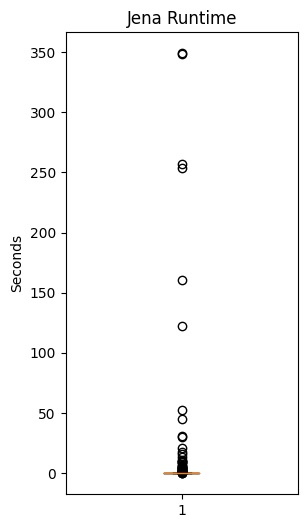

In [61]:
bxp_plot(j_rt_train, title='Jena Runtime')

In [62]:
for i, t in zip([j_rt_train,bf_rt_train, j_rt_val,bf_rt_val, j_rt_test,bf_rt_test],
                ['Jena Runtime Traininig','Bloom Filter Runtimes Trainining','Jena Runtime Validation','Bloom Filter Runtime Validation',
                'Jena Runtime Test','Bloom Filter Runtimes Test']):
    #bxp_plot(i, title=t)
    pass

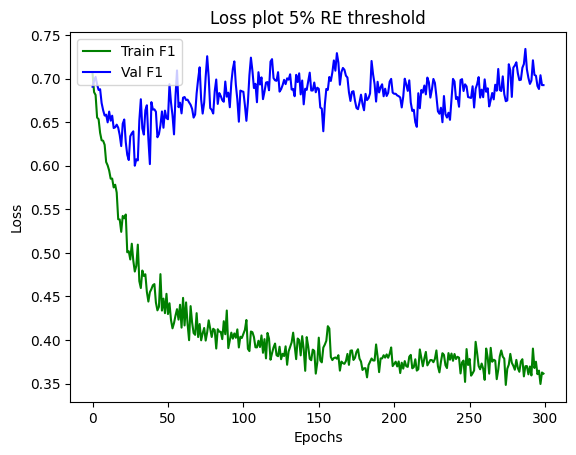

In [63]:
plt.title('Loss plot 5% RE threshold')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(results['train_loss'],'-g', label='Train F1')
plt.plot(results['val_loss'],'-b', label='Val F1')
plt.legend(loc='upper left')
#plt.ylim([0.0,1.0])

In [64]:
print('best val loss epoch: ', np.argmin(results['val_loss'])+1)
best_val_epoch = np.argmin(results['val_loss'])+1

best val loss epoch:  29
